In [21]:
import os

from google.cloud import bigquery

# Fetch Credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'resource/local-receiver-341803-261a3b7beea6.json'

# Build BigQuery Client
client = bigquery.Client()

In [22]:
# Query for Position Histories from BigQuery
QUERY = ('SELECT lastTrainReporting.positionHistoryList FROM `local-receiver-341803.PairingSession.TrainDataTable` LIMIT 1')
query_job = client.query(QUERY)

# Wait for job to finish
rows = query_job.result()

# Fetch each position time and milepost
positionMilepostTimes = []

for row in rows:
    for positionHistory in row.get('positionHistoryList'):
        # The time that the train was at the specific milepost
        # Record the position time as seconds from epoch to use in linear regression model
        positionTime = positionHistory.get('positionTime').timestamp()
        # The unique identifier fo the milepost
        milepostNumber = positionHistory.get('milepostLocation').get('milepost').get('milepostNumber')

        positionMilepostTimes.append([positionTime, milepostNumber])

positionMilepostTimes

[[1648747759.0, 278.9611],
 [1648747673.0, 279.8213],
 [1648747517.0, 281.4215],
 [1648747370.0, 282.9552],
 [1648747223.0, 284.4973]]

In [23]:
import numpy as np

from sklearn.linear_model import LinearRegression

# Stage data
X = np.array(positionMilepostTimes)[:,0].reshape(-1,1)
y = np.array(positionMilepostTimes)[:,1].reshape(-1,1)

# Fit the linear regression model
regsr=LinearRegression()
regsr.fit(X,y)

LinearRegression()

In [24]:
import datetime

# Build predicition set
to_predict_x = [datetime.datetime(2022, 3, 31, 17, 20, 23, tzinfo=datetime.timezone.utc).timestamp()]
to_predict_x = np.array(to_predict_x).reshape(-1,1)

# Predict 
predicted_y = regsr.predict(to_predict_x)

m = regsr.coef_
c = regsr.intercept_

print("Predicted y:\n", predicted_y)
print("slope (m): ", m)
print("y-intercept (c): " , c)

Predicted y:
 [[284.48159566]]
slope (m):  [[-0.01033748]]
y-intercept (c):  [17044169.36234174]


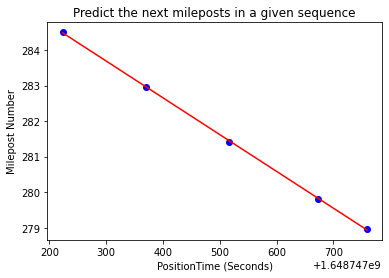

In [25]:
import matplotlib.pyplot as plt

plt.title('Predict the next mileposts in a given sequence')  
plt.xlabel('PositionTime (Seconds)')  
plt.ylabel('Milepost Number')
plt.scatter(X,y,color="blue")

new_y = [m*i+c for i in np.append(X,to_predict_x)]
new_y = np.array(new_y).reshape(-1,1)

plt.plot(np.append(X,to_predict_x),new_y,color="red")
plt.show()